In [1]:
from gym.spaces import Discrete, Tuple
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.ndimage.measurements import label
import gym
from gym import error, spaces, utils
from gym.utils import seeding
import numpy as np
import copy
class PackEnv2(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, board_shape = (5, 5), input_shapes=[],max_moves=100, replacement=True):
        self.counter = 0
        self.max_moves = max_moves
        self.done = False
        self.reward = 0
        self.board_shape = board_shape
        self.observation_space = np.zeros((board_shape[0], board_shape[1]*2))
        self.action_space = Discrete(board_shape[0]*board_shape[1]+1)
        self.state = [np.zeros(board_shape),np.zeros(board_shape)]
        self.return_state = np.concatenate((self.state[0], self.state[1]), axis=1)
        self.replace = replacement

        self.num_possible_moves = board_shape[0]*board_shape[1]

        if len(input_shapes) == 0:
            mat = np.zeros(board_shape)
            mat[0][0] = 1
            self.shapes = [mat]
        else:
            self.shapes = []
            for shape in input_shapes:
                base_mat = np.zeros(board_shape)
                for i in range(len(shape)):
                    for j in range(len(shape[0])):
                        base_mat[i][j] = shape[i][j]
                self.shapes.append(base_mat)
        self.remaining_shapes = copy.deepcopy(self.shapes)
        val = random.choice(range(len(self.shapes)))
        self.state[1] = self.shapes[val]
        if not self.replace:
            self.remaining_shapes.pop(val)

    def reset(self):
        val = random.choice(range(len(self.shapes)))
        random_shape = self.shapes[val]
        self.counter = 0
        self.done = False
        self.reward = 0
        self.state = [np.zeros(self.board_shape), random_shape]
        self.return_state = np.concatenate((self.state[0], self.state[1]), axis=1)
        self.remaining_shapes = copy.deepcopy(self.shapes)
        if not self.replace:
            self.remaining_shapes.pop(val)
        return self.return_state


    def valid_move(self, target):
        state = self.state
        board = state[0]
        piece = state[1]
        h = self.board_shape[0]
        w = self.board_shape[1]

        #do nothing
        if target == h * w:
            return True

        if target > h*w or target < 0:
            return False

        h_offset = int(target / h)
        w_offset = target % w

        for H in range(len(piece)):
            for W in range(len(piece[0])):
                if piece[H][W] == 1:
                    if (h_offset + H >= h) or (w_offset + W  >= w):
                        return False
                    if board[H+h_offset][W+w_offset] == 1:
                        return False
        return True


    def calculate_reward(self, target, divisor=20):
        state = self.state
        board = state[0]
        h = self.board_shape[0]
        w = self.board_shape[1]
        if target == self.num_possible_moves:
            return -.5
        
        

        #connection structure
        #structure = np.ones((3, 3), dtype=np.int)
        structure = np.array([[0,1,0],[1,1,1],[0,1,0]])
        labeled, ncomponents = label(board, structure)
        component_num = labeled[int(target/h)][target % w]
        if component_num == 0:
            #invalid
            return -1
        indices = np.indices(board.shape).T[:,:,[1, 0]]
        component = indices[labeled == component_num]

        size = len(component)
        max_h = max([pair[0] for pair in component])
        min_h = min([pair[0] for pair in component])
        max_w = max([pair[1] for pair in component])
        min_w = min([pair[1] for pair in component])
        block_size = abs(max_h-min_h + 1)*abs(max_w-min_w + 1)
        return size**2/block_size/divisor

    def merge(self, target):
        state = self.state
        board = state[0]
        piece = state[1]
        h = self.board_shape[0]
        w = self.board_shape[1]

        #do nothing
        if target == h * w:
            return state[0]

        h_offset = int(target / h)
        w_offset = target % w

        for H in range(len(piece)):
            for W in range(len(piece[0])):
                if piece[H][W] == 1:
                    #print("HIIIIIII")
                    board[H+h_offset][W+w_offset] = 1
        return board

    def final_reward(self):
        h = self.board_shape[0]
        w = self.board_shape[1]
        state = self.state
        board = state[0]
        if np.sum(board) == h*w:
            return 1
        else:
            return -1
        

    def step(self, target):
        h = self.board_shape[0]
        w = self.board_shape[1]
        if self.done == True:
            self.reward = self.final_reward()
            print("It's over")
            return [self.return_state, self.reward, self.done, {}]
        elif target > self.num_possible_moves:
            print("Impossible. Invalid position")
            return [self.return_state, self.reward, self.done, {}]
        else:
            self.counter+=1
            #print("counter", self.counter)
            if (self.counter == self.max_moves):
                self.done = True
                self.reward = self.final_reward()                
                return [self.return_state, self.reward, self.done, {}]
            #self.state[0][int(target/h)][target%k] = 1
            if not self.valid_move(target):
                self.reward = -1
                return [self.return_state, self.reward, self.done, {}]

            updated_board = self.merge(target)
            self.reward = self.calculate_reward(target)
            self.state[0] = updated_board
            
            #do nothing so same state
            if (target == h*w):
                return [self.return_state, self.reward, self.done, {}]
            #no pieces left so we're done
            if len(self.remaining_shapes) == 0:
                print("hi")
                self.state[1] = np.zeros(self.board_shape)
                self.return_state = np.concatenate((self.state[0], self.state[1]), axis=1)
                self.done = True
                self.reward = self.final_reward()
                return [self.return_state, self.reward, self.done, {}]
            else:
                val = random.choice(range(len(self.remaining_shapes)))
                self.state[1] = self.remaining_shapes[val]
                if not self.replace:
                    self.remaining_shapes.pop(val)
                self.return_state = np.concatenate((self.state[0], self.state[1]), axis=1)
                return [self.return_state, self.reward, self.done, {}]


    def render(self, mode='human'):
        fig, ax = plt.subplots()
        # define the colors
        cmap = mpl.colors.ListedColormap(['w', 'k'])

        # create a normalize object the describes the limits of
        # each color
        bounds = [0., 0.5, 1.]
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

        # plot it
        ax.imshow(self.state[0], interpolation='none', cmap=cmap, norm=norm)
    def render_piece(self, mode='human'):
        fig, ax = plt.subplots()
        # define the colors
        cmap = mpl.colors.ListedColormap(['w', 'k'])

        # create a normalize object the describes the limits of
        # each color
        bounds = [0., 0.5, 1.]
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

        # plot it
        ax.imshow(self.state[1], interpolation='none', cmap=cmap, norm=norm)

In [2]:
%%capture
import gym
#import gym_pack
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
import keras

from collections import deque

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.optimizers import Adam
from keras import layers, models

from rl.agents.cem import CEMAgent
from rl.memory import EpisodeParameterMemory

In [98]:
class PrupeQN:
    def __init__(self, env):
        self.env     = env
        self.memory  = deque(maxlen=10000)
        self.step = (1,1)
        self.subgrid_shape = (2,2)
        
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        self.learning_rate = 0.01
        self.tau = .08
        self.min_tau = .02
        self.tau_decay = .999

        self.model        = self.create_model()
        self.target_model = self.create_model()
        
        
    

    
    #some env methods copied
    
    def valid_move(self,state, target):
        h = self.env.board_shape[0]
        w = self.env.board_shape[1]
        state = (state[:,:w], state[:, w:])
        board = state[0]
        piece = state[1]
        

        #do nothing
        if target == h * w:
            return True

        if target > h*w or target < 0:
            return False

        h_offset = int(target / h)
        w_offset = target % w

        for H in range(len(piece)):
            for W in range(len(piece[0])):
                if piece[H][W] == 1:
                    if (h_offset + H >= h) or (w_offset + W  >= w):
                        return False
                    if board[H+h_offset][W+w_offset] == 1:
                        return False
        return True
    def merge(self, state, target):
        h = self.env.board_shape[0]
        w = self.env.board_shape[1]
        state = (state[:,:w], state[:, w:])
        board = state[0]
        piece = state[1]
        

        #do nothing
        if target == h * w:
            return state[0]

        h_offset = int(target / h)
        w_offset = target % w

        for H in range(len(piece)):
            for W in range(len(piece[0])):
                if piece[H][W] == 1:
                    #print("HIIIIIII")
                    board[H+h_offset][W+w_offset] += 1
        return board
    
    
    def grid_preprocess(self, board):
        return
    #input should be a binary array describing which action we are taking
    #along with the current state space which is made smaller by solving 
    #using subproblems and then put through several convolutional layers
    #then this is put through several fully connected layers and finally
    #output through a single node
    def create_model(self):
        h, w = self.env.board_shape
        h_step, w_step = self.step
        h_len, w_len = self.subgrid_shape
        updated_shape = (int((h-h_len+1)/h_step), int((w-w_len+1)/w_step))
        
        input_shape = updated_shape + (1,)
        vals_shape = (self.env.num_possible_moves+1,)
        
        input1 = layers.Input(shape=input_shape)
        input2 = layers.Input(shape=vals_shape)
        conved1 = layers.Conv2D(32, (5, 5),padding="same",input_shape=input_shape, activation="relu")(input1)
        conved2 = layers.Conv2D(32, (5, 5),padding="same",input_shape=input_shape, activation="relu")(conved1)
        compressed = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(conved2)
        x = Flatten()(compressed)
        processed = Dense(self.env.num_possible_moves+1, activation="relu")(x)

        merged = keras.layers.Concatenate(axis=1)([processed, input2])
        a = Dense(24, activation="relu")(merged)
        b = Dense(48, activation="relu")(a)
        output = Dense(1, activation="linear")(b)
        model = keras.models.Model(inputs=[input1, input2], output=output)
        model.compile(loss="mean_squared_error",
            optimizer=Adam(lr=.01))
        print(model.summary())
        return model

    
    #eventually replaced with network on previous values TODO
    def subgrid_val(self, subgrid):
        #print("subgrid",subgrid, np.sum(subgrid))
        
        #illegal move
        if np.max(subgrid) == 2:
            return -1
        elif np.sum(subgrid) == 0:
            return 0
        elif np.sum(subgrid) == 1:
            return .2
        elif subgrid[0][0] == subgrid[1][1] and np.sum(subgrid) == 2:
            return -.5
        elif subgrid[0][0] != subgrid[1][1] and np.sum(subgrid) == 2:
            return .4
        elif np.sum(subgrid) == 3:
            return .5
        elif np.sum(subgrid) == 4:
            return 1
        return 0
    
    def preprocess(self, state, action):
        #print("STATE", state, "ACTION", action)
        h, w = self.env.board_shape
        h_step, w_step = self.step
        h_len, w_len = self.subgrid_shape
        if not self.valid_move(state, action):
            vals = -np.ones((int((h-h_len+1)/h_step), int((w-w_len+1)/w_step)))
            return np.expand_dims(vals, axis=2)
        potential_board = np.array(self.merge(state, action))
        #print("potential board is", potential_board)
        
        vals = []
        for i in range(0, h-h_len+1, h_step):
            for j in range(0, w-w_len+1, w_step):
                subgrid = potential_board[i:i+h_len, j:j+w_len]
                vals.append(self.subgrid_val(subgrid))
        
        vals = np.array(vals)
        vals = vals.reshape(int((h-h_len+1)/h_step), int((w-w_len+1)/w_step), order='F')
        #print("preprocessed is ", vals)
        return np.expand_dims(vals, axis=2)

    
    def max_q(self, state):
        #print("max_q state is", state)
        #new_shape = (1,) + self.env.observation_space.shape + (1,)
        #input_state = state.reshape(new_shape)
        actions = np.array([[int(j == i) for j in range(self.env.num_possible_moves+1)] for i in range(self.env.num_possible_moves+1)])
        #input_states = np.array(list(input_state)*(self.env.num_possible_moves+1))
        state = state.reshape(self.env.observation_space.shape)
        input_states = [self.preprocess(np.copy(state), action) for action in range(self.env.num_possible_moves+1)]
        input_states = np.array(input_states)
        
        #PREPREOCESS INPUT STATES
        q_vals = self.target_model.predict([input_states, actions])
        return max(q_vals)
        
    
    def act(self, state):
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        
        
        #new_shape = (1,) + self.env.observation_space.shape + (1,)
        #input_state = state.reshape(new_shape)
        actions = np.array([[int(j == i) for j in range(self.env.num_possible_moves+1)] for i in range(self.env.num_possible_moves+1)])
        #input_states = np.array(list(input_state)*(self.env.num_possible_moves+1))
        
        state = state.reshape(self.env.observation_space.shape)
        #print("prior state is ", state)
        input_states = [self.preprocess(np.copy(state), action) for action in range(self.env.num_possible_moves+1)]
        #print("posterior state is ", state)
        input_states = np.array(input_states)
        #PREPROCESS INPUT STATES
        predictions = self.model.predict([input_states, actions])
        for i in range(len(predictions)):
            if not self.env.valid_move(i):
                pass
        return np.argmax(predictions)
    
    def trained_act(self, state):
        #new_shape = (1,) + self.env.observation_space.shape + (1,)
        #input_state = state.reshape(new_shape)
        actions = np.array([[int(j == i) for j in range(self.env.num_possible_moves+1)] for i in range(self.env.num_possible_moves+1)])
        #input_states = np.array(list(input_state)*(self.env.num_possible_moves+1))
        
        state = state.reshape(self.env.observation_space.shape)
        input_states = [self.preprocess(np.copy(state), action) for action in range(self.env.num_possible_moves+1)]
        input_states = np.array(input_states)
        #PREPROCESS INPUT STATES
        predictions = self.model.predict([input_states, actions])
        for i in range(len(predictions)):
            if not self.env.valid_move(i):
                pass
        return np.argmax(predictions)

    def remember(self, state, action, reward, new_state, done):
        self.memory.append([state, action, reward, new_state, done])

    def replay(self):
        batch_size = 32
        if len(self.memory) < batch_size: 
            return

        samples = random.sample(self.memory, batch_size)
        states = []
        outputs = []
        actions = []
        for sample in samples:
            state, action, reward, new_state, done = sample
            
            output_prime = 0
            if done:
                output_prime = reward
            else:
                Q_future = self.max_q(new_state)
                output_prime = reward + Q_future * self.gamma
            outputs.append(output_prime)
            #states.extend(state)
            state = state.reshape(self.env.observation_space.shape)
            states.append(self.preprocess(np.copy(state), action))
            actions.append([int(j == action) for j in range(self.env.num_possible_moves+1)])
        print("reward is", reward, "output_prime is", output_prime)
        states = np.array(states)
        outputs = np.array(outputs)
        actions = np.array(actions)
        
        #PREPROCESS STATES
        self.model.fit([states,actions], outputs, epochs=1, verbose=0)

    def target_train(self):
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        self.tau = max(self.min_tau, self.tau*self.tau_decay)
        for i in range(len(target_weights)):
            target_weights[i] = weights[i] * self.tau + target_weights[i] * (1 - self.tau)
        self.target_model.set_weights(target_weights)

    def save_model(self, fn):
        self.model.save(fn)




In [123]:
def main():
    #env = PackEnv2(board_shape=(2,2), input_shapes=[[[1]]]*2+[[[1,1],[0,0]]], replacement=False, max_moves=4)
    max_moves = 8
    env = PackEnv2(board_shape=(4,4), input_shapes=[[[1]]]*4+[[[1,1],[1,1]]]*3, replacement=False, max_moves=max_moves)
    gamma   = 0.95
    epsilon = .99

    trials  = 501
    trial_len = 50

    # updateTargetNetwork = 1000
    dqn_agent = PrupeQN(env=env)
    accuracies = []
    for trial in range(trials):
        cur_state = env.reset()
        state_shape = (1,) + env.observation_space.shape + (1,)
        cur_state = cur_state.reshape(state_shape)
        for step in range(trial_len):
            action = dqn_agent.act(cur_state)
            new_state, reward, done, _ = env.step(action)
            
            new_state = new_state.reshape(state_shape)
            dqn_agent.remember(cur_state, action, reward, new_state, done)
            
            dqn_agent.replay()       # internally iterates default (prediction) model
            dqn_agent.target_train() # iterates target model

            cur_state = new_state
            if done:
                break
        
        if (trial % 10) == 0 and trial !=0:
            total_accuracy = 0
            for i in range(30):
                accuracy = 0
                new_state = env.reset()
                for j in range(max_moves):
                    action = dqn_agent.trained_act(new_state)
                    new_state, reward, done, _ = env.step(action)
                    board_width = env.board_shape[1]
                accuracy = np.sum(new_state[:,:board_width])/env.num_possible_moves
                print("sub accuracy is", accuracy)

                total_accuracy += accuracy/30
            accuracies.append(total_accuracy)
            print("accuracy is ", total_accuracy)
        print("trial #{}".format(trial))
        
        
        
    return env, dqn_agent, accuracies

In [126]:
env, agent, accuracies3 = main()


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


Model: "model_71"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_141 (InputLayer)          (None, 3, 3, 1)      0                                            
__________________________________________________________________________________________________
conv2d_141 (Conv2D)             (None, 3, 3, 32)     832         input_141[0][0]                  
__________________________________________________________________________________________________
conv2d_142 (Conv2D)             (None, 3, 3, 32)     25632       conv2d_141[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_71 (MaxPooling2D) (None, 2, 2, 32)     0           conv2d_142[0][0]                 
___________________________________________________________________________________________

sub accuracy is 0.375
sub accuracy is 0.5
sub accuracy is 0.375
sub accuracy is 0.75
sub accuracy is 0.625
sub accuracy is 0.4375
sub accuracy is 0.4375
sub accuracy is 0.4375
sub accuracy is 0.375
sub accuracy is 0.6875
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.375
sub accuracy is 0.4375
sub accuracy is 0.375
sub accuracy is 0.75
sub accuracy is 0.375
sub accuracy is 0.625
accuracy is  0.5437500000000001
trial #10
reward is -1 output_prime is [0.81874764]
reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is -1 output_prime is [0.5435426]
reward is -1 output_prime is [0.3669293]
reward is -1 output_prime is [0.49710572]
reward is 0.05 output_prime is [1.412483]
reward is -1 output_prime is [-0.10646451]
trial #11
reward is -1 output_prime is -1
reward is -1 output_prime is [0.47876954]
reward is -1 output_prime is [0.5819702]
reward is -1 output_prime is [0.5991614]
reward is 0.05 output_prime is [1.1381336]
reward is 0.20833333333333334 output_prime is [1

sub accuracy is 0.6875
sub accuracy is 0.6875
sub accuracy is 0.5
sub accuracy is 0.375
sub accuracy is 0.5
sub accuracy is 0.5625
sub accuracy is 0.4375
sub accuracy is 0.625
sub accuracy is 0.4375
sub accuracy is 0.5625
sub accuracy is 0.5
sub accuracy is 0.625
accuracy is  0.5333333333333333
trial #30
reward is 0.05 output_prime is [2.6813176]
reward is -1 output_prime is [1.0926905]
reward is -1 output_prime is -1
reward is -1 output_prime is [1.6211803]
reward is -1 output_prime is -1
reward is 0.20833333333333334 output_prime is [3.188376]
reward is -1 output_prime is [2.0501335]
reward is -1 output_prime is [2.043634]
trial #31
reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is -1 output_prime is [1.2442949]
reward is 0.26666666666666666 output_prime is [2.0021703]
reward is -1 output_prime is [1.7331331]
reward is 0.2 output_prime is [1.5263165]
reward is -1 output_prime is -1
reward is -1 output_prime is [1.8171036]
trial #32
reward is -1 output_prime is

sub accuracy is 0.4375
sub accuracy is 0.3125
sub accuracy is 0.25
sub accuracy is 0.625
sub accuracy is 0.375
sub accuracy is 0.3125
sub accuracy is 0.3125
sub accuracy is 0.375
sub accuracy is 0.5
sub accuracy is 0.3125
sub accuracy is 0.5
sub accuracy is 0.375
sub accuracy is 0.375
sub accuracy is 0.4375
sub accuracy is 0.375
sub accuracy is 0.75
sub accuracy is 0.3125
sub accuracy is 0.4375
sub accuracy is 0.25
sub accuracy is 0.3125
sub accuracy is 0.375
accuracy is  0.3937500000000001
trial #50
reward is -1 output_prime is [3.772439]
reward is -1 output_prime is [3.4244595]
reward is 0.378125 output_prime is [2.7169237]
reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is -1 output_prime is [1.7935622]
reward is 0.05 output_prime is [2.7054217]
reward is -1 output_prime is -1
trial #51
reward is -1 output_prime is -1
reward is -1 output_prime is [1.4551997]
reward is -1 output_prime is [1.2073002]
reward is 0.05 output_prime is [3.6576886]
reward is -1 output

sub accuracy is 0.5625
sub accuracy is 0.4375
sub accuracy is 0.4375
sub accuracy is 0.4375
sub accuracy is 0.6875
sub accuracy is 0.5625
sub accuracy is 0.3125
sub accuracy is 0.4375
sub accuracy is 0.4375
sub accuracy is 0.4375
sub accuracy is 0.5
sub accuracy is 0.375
sub accuracy is 0.75
sub accuracy is 0.4375
sub accuracy is 0.3125
sub accuracy is 0.5
sub accuracy is 0.75
sub accuracy is 0.75
sub accuracy is 0.375
sub accuracy is 0.375
sub accuracy is 0.75
accuracy is  0.5083333333333335
trial #70
reward is -1 output_prime is [2.769715]
reward is 0.05 output_prime is [1.3798044]
reward is 0.2 output_prime is [3.8537962]
reward is -1 output_prime is [2.499675]
reward is 0.2 output_prime is [3.3861737]
reward is -1 output_prime is -1
reward is 0.26666666666666666 output_prime is [3.3989213]
reward is 0.20833333333333334 output_prime is [3.7161064]
trial #71
reward is -1 output_prime is -1
reward is -1 output_prime is [1.3068552]
reward is -1 output_prime is [2.2166173]
reward is -1 

sub accuracy is 0.625
sub accuracy is 0.5
sub accuracy is 0.75
sub accuracy is 0.6875
sub accuracy is 0.5
sub accuracy is 0.75
sub accuracy is 0.6875
sub accuracy is 0.5
sub accuracy is 0.4375
sub accuracy is 0.4375
sub accuracy is 0.5625
sub accuracy is 0.6875
sub accuracy is 0.6875
sub accuracy is 0.6875
sub accuracy is 0.6875
sub accuracy is 0.625
sub accuracy is 0.75
sub accuracy is 0.75
sub accuracy is 0.75
sub accuracy is 0.6875
sub accuracy is 0.6875
accuracy is  0.6416666666666667
trial #90
reward is 0.20833333333333334 output_prime is [4.231533]
reward is -1 output_prime is [1.2421732]
reward is 0.05 output_prime is [1.2286115]
reward is 0.05 output_prime is [1.2266198]
reward is 0.4166666666666667 output_prime is [1.590729]
reward is -1 output_prime is -1
reward is 0.3125 output_prime is [3.7855213]
reward is 0.20416666666666666 output_prime is [1.7864851]
trial #91
reward is 0.20416666666666666 output_prime is [3.037457]
reward is -1 output_prime is -1
reward is -1 output_pr

sub accuracy is 0.5
sub accuracy is 0.3125
sub accuracy is 0.625
sub accuracy is 0.4375
sub accuracy is 0.6875
sub accuracy is 0.6875
sub accuracy is 0.75
sub accuracy is 0.6875
sub accuracy is 0.6875
sub accuracy is 0.4375
sub accuracy is 0.6875
sub accuracy is 0.3125
sub accuracy is 0.4375
sub accuracy is 0.4375
sub accuracy is 0.6875
sub accuracy is 0.6875
sub accuracy is 0.5625
sub accuracy is 0.5
sub accuracy is 0.5
sub accuracy is 0.3125
sub accuracy is 0.6875
sub accuracy is 0.75
sub accuracy is 0.3125
sub accuracy is 0.6875
sub accuracy is 0.75
sub accuracy is 0.4375
accuracy is  0.5541666666666666
trial #110
reward is 0.3375 output_prime is [2.3923628]
reward is 0.26666666666666666 output_prime is [2.3636017]
reward is -1 output_prime is [1.1056087]
reward is 0.3375 output_prime is [3.1763024]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [2.3104227]
reward is -1 output_prime is [0.27803135]
reward is -1 output_prime is [2.188217]
trial #111
reward is 0.05 out

reward is -1 output_prime is [1.6238377]
sub accuracy is 0.75
sub accuracy is 0.75
sub accuracy is 0.6875
sub accuracy is 0.625
sub accuracy is 0.6875
sub accuracy is 0.75
sub accuracy is 0.75
sub accuracy is 0.9375
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.375
sub accuracy is 0.4375
sub accuracy is 0.6875
sub accuracy is 0.4375
sub accuracy is 0.75
sub accuracy is 0.625
sub accuracy is 0.6875
sub accuracy is 0.9375
sub accuracy is 0.75
sub accuracy is 0.75
sub accuracy is 0.75
sub accuracy is 0.625
sub accuracy is 0.375
sub accuracy is 0.75
sub accuracy is 0.75
sub accuracy is 0.75
sub accuracy is 0.75
sub accuracy is 0.75
sub accuracy is 0.75
sub accuracy is 0.625
sub accuracy is 0.375
accuracy is  0.6875000000000001
trial #130
reward is 0.2 output_prime is [2.8128314]
reward is -0.5 output_prime is [1.4575155]
reward is -1 output_prime is [1.1111696]
reward is 0.5041666666666667 output_prime is [0.91411114]
reward is -1 output_prime is [-0.59270215]
reward is 0.266666666666

reward is -1 output_prime is [1.199688]
reward is 0.378125 output_prime is [1.4117689]
trial #149
reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is -1 output_prime is [-0.7222434]
reward is 0.26666666666666666 output_prime is [2.5182292]
reward is 0.3125 output_prime is [1.8619746]
reward is 0.05 output_prime is [2.4383426]
reward is -0.5 output_prime is [0.9503484]
reward is 0.2 output_prime is [2.5796428]
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.625
sub accuracy is 0.6875
sub accuracy is 0.75
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.75
sub accuracy is 0.6875
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.75
sub accuracy is 0.6875
sub accuracy is 0.5
sub accuracy is 0.75
sub accuracy is 0.5
sub accuracy is 0.75
sub accuracy is 0.6875
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.6875
sub accuracy is 0.75
sub accuracy is 0.75
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.6875
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.62

reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is -1 output_prime is [0.5500456]
reward is -1 output_prime is [0.7449912]
reward is 0.05 output_prime is [2.1237297]
reward is 0.05 output_prime is [2.2026577]
reward is -1 output_prime is [-0.06589222]
trial #169
reward is 0.2 output_prime is [2.234842]
reward is -1 output_prime is [-0.9248602]
reward is -1 output_prime is -1
reward is 0.2 output_prime is [2.1406548]
reward is -1 output_prime is [-0.69387686]
reward is 0.378125 output_prime is [1.6145699]
reward is 0.378125 output_prime is [1.2826972]
reward is -1 output_prime is [-0.6922329]
sub accuracy is 0.6875
sub accuracy is 0.5625
sub accuracy is 0.6875
sub accuracy is 0.75
sub accuracy is 0.5625
sub accuracy is 0.75
sub accuracy is 0.6875
sub accuracy is 0.75
sub accuracy is 0.75
sub accuracy is 0.5625
sub accuracy is 0.9375
sub accuracy is 0.625
sub accuracy is 0.6875
sub accuracy is 0.6875
sub accuracy is 0.6875
sub accura

reward is 0.2 output_prime is [1.9456053]
reward is -1 output_prime is [-1.1128592]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [1.214042]
trial #188
reward is 0.05 output_prime is [2.3092628]
reward is -0.5 output_prime is [0.449907]
reward is 0.20833333333333334 output_prime is [1.5203716]
reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is -1 output_prime is [0.9724324]
reward is -0.5 output_prime is [1.0266097]
reward is -0.5 output_prime is [0.68631935]
trial #189
reward is -1 output_prime is -1
reward is 0.2 output_prime is [2.1695104]
reward is -1 output_prime is -1
reward is -1 output_prime is [-1.0985684]
reward is 0.2 output_prime is [2.1110146]
reward is 0.2 output_prime is [2.2774482]
reward is 0.2 output_prime is [0.76553965]
reward is 0.2 output_prime is [2.1691062]
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.6875
sub accuracy is 0.9375
sub accuracy is 0.6875
sub accuracy is 0.75
sub accuracy is 0.75
sub accuracy is 0.75
sub

reward is 0.20833333333333334 output_prime is [1.5128584]
reward is -1 output_prime is [-0.5008539]
reward is 0.2 output_prime is [1.821062]
reward is 0.2 output_prime is [1.6351994]
trial #207
reward is -1 output_prime is [0.03316879]
reward is -1 output_prime is -1
reward is -1 output_prime is [-1.1086485]
reward is 0.20416666666666666 output_prime is [0.09482536]
reward is 0.1 output_prime is [-0.01003982]
reward is -1 output_prime is -1
reward is 0.2 output_prime is [1.404125]
reward is 0.05 output_prime is [1.2505072]
trial #208
reward is 0.2 output_prime is [0.08670399]
reward is -1 output_prime is [-1.1140563]
reward is -1 output_prime is [0.20435452]
reward is -1 output_prime is -1
reward is 0.1 output_prime is [1.6470683]
reward is -1 output_prime is [0.15067911]
reward is -1 output_prime is [0.5797684]
reward is -1 output_prime is -1
trial #209
reward is -1 output_prime is [-0.171233]
reward is 0.45 output_prime is [0.43802208]
reward is 0.2 output_prime is [1.5105072]
reward

reward is -1 output_prime is [-0.13302141]
reward is -0.5 output_prime is [0.01001167]
reward is 0.703125 output_prime is [0.6591063]
reward is 0.2 output_prime is [0.87730396]
reward is 0.20416666666666666 output_prime is [0.7745424]
reward is 0.20833333333333334 output_prime is [1.0188593]
trial #226
reward is 0.20833333333333334 output_prime is [1.0884578]
reward is -1 output_prime is [-1.3539587]
reward is 0.2 output_prime is [1.6766077]
reward is 0.4 output_prime is [1.6610684]
reward is 0.4166666666666667 output_prime is [1.2201672]
reward is -1 output_prime is [0.04025817]
reward is 0.2 output_prime is [1.8051958]
reward is -1 output_prime is [-0.92691946]
trial #227
reward is -1 output_prime is [0.03289485]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [1.3882669]
reward is 0.2 output_prime is [1.8430005]
reward is 0.5041666666666667 output_prime is [1.0115278]
reward is 0.2 output_prime is [1.3160753]
reward is -1 output_prime is [-0.14947915]
reward is 0.2 ou

reward is -1 output_prime is [-1.4747972]
reward is -1 output_prime is [0.16517997]
reward is 0.26666666666666666 output_prime is [1.5704646]
reward is -0.5 output_prime is [0.7141788]
reward is 0.45 output_prime is [-0.0240081]
reward is 0.2 output_prime is [1.294069]
trial #245
reward is 0.378125 output_prime is [0.8172219]
reward is 0.1 output_prime is [1.367153]
reward is -1 output_prime is -1
reward is 0.378125 output_prime is [0.96921855]
reward is -0.5 output_prime is [-0.10065499]
reward is -1 output_prime is [-1.4695021]
reward is 0.05 output_prime is [0.82759553]
reward is -0.5 output_prime is [0.18895203]
trial #246
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.41614053]
reward is -1 output_prime is [0.5842477]
reward is -0.5 output_prime is [-0.96468776]
reward is 0.05 output_prime is [1.3717165]
reward is 0.4166666666666667 output_prime is [0.90144795]
reward is 0.20833333333333334 output_prime is [1.0081775]
reward is 0.4166666666666667 output_prime i

reward is 0.05 output_prime is [1.306732]
reward is 0.05 output_prime is [1.3940756]
reward is 0.2 output_prime is [1.429411]
reward is 0.05 output_prime is [0.79143673]
reward is -0.5 output_prime is [0.5474986]
reward is 0.6125 output_prime is [0.73203415]
reward is -1 output_prime is -1
trial #264
reward is -1 output_prime is [-1.6401808]
reward is -1 output_prime is [0.23520291]
reward is -1 output_prime is [0.40844297]
reward is 0.378125 output_prime is [0.9573756]
reward is 0.3375 output_prime is [1.2641346]
reward is -1 output_prime is [-0.6371488]
reward is 0.05 output_prime is [1.1305758]
reward is -1 output_prime is -1
trial #265
reward is 0.05 output_prime is [1.1238309]
reward is -0.5 output_prime is [-1.1396081]
reward is 0.05 output_prime is [-0.58888245]
reward is 0.2 output_prime is [1.0827379]
reward is -1 output_prime is [-0.20525247]
reward is 0.3375 output_prime is [-0.29981568]
reward is 0.3125 output_prime is [0.756956]
reward is 0.2 output_prime is [0.6592069]
tr

reward is 0.3125 output_prime is [0.93526614]
reward is 0.378125 output_prime is [-0.34407675]
reward is 0.05 output_prime is [0.9912939]
reward is 0.2 output_prime is [0.71933115]
reward is 0.3375 output_prime is [1.5591584]
reward is 0.3 output_prime is [0.19940929]
reward is 0.26666666666666666 output_prime is [0.8416207]
reward is 0.378125 output_prime is [0.6020158]
trial #283
reward is -1 output_prime is -1
reward is 0.05 output_prime is [1.1357195]
reward is -1 output_prime is [-0.57129276]
reward is 0.1125 output_prime is [0.82011646]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [1.1060884]
reward is -1 output_prime is [0.05657828]
reward is 0.20833333333333334 output_prime is [0.6114711]
trial #284
reward is 0.4 output_prime is [0.8155596]
reward is 0.20833333333333334 output_prime is [0.99490356]
reward is 0.3375 output_prime is [-0.37700644]
reward is 0.3375 output_prime is [0.90196645]
reward is 0.20833333333333334 output_prime is [1.2383031]
reward is -1 

reward is -1 output_prime is [-1.6692111]
reward is 0.3125 output_prime is [0.8747916]
reward is 0.05 output_prime is [-0.6217622]
reward is 0.3375 output_prime is [1.0537806]
reward is 0.3 output_prime is [0.7071508]
reward is 0.2 output_prime is [1.2362435]
trial #301
reward is -0.5 output_prime is [-0.9738825]
reward is 0.05 output_prime is [1.0680206]
reward is 0.20833333333333334 output_prime is [0.60851634]
reward is -0.5 output_prime is [0.32851875]
reward is -1 output_prime is -1
reward is 1 output_prime is 1
reward is 0.20416666666666666 output_prime is [0.43198365]
reward is -1 output_prime is -1
trial #302
reward is 0.3375 output_prime is [0.6140008]
reward is 0.20833333333333334 output_prime is [0.7297744]
reward is -1 output_prime is [-1.6716113]
reward is 0.3375 output_prime is [1.0957135]
reward is 0.05 output_prime is [0.5983634]
reward is -0.5 output_prime is [0.5388038]
reward is 0.3375 output_prime is [0.6395403]
reward is 0.225 output_prime is [0.9544128]
trial #303

sub accuracy is 0.75
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.9375
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.9375
sub accuracy is 0.75
sub accuracy is 0.9375
sub accuracy is 0.75
sub accuracy is 0.9375
sub accuracy is 0.5625
sub accuracy is 0.75
sub accuracy is 0.9375
sub accuracy is 0.75
sub accuracy is 0.6875
hi
It's over
sub accuracy is 1.0
accuracy is  0.8437500000000002
trial #320
reward is -0.5 output_prime is [-0.844959]
reward is -0.5 output_prime is [-1.2050326]
reward is -1 output_prime is -1
reward is -1 output_prime is [-1.3752909]
reward is -1 output_prime is -1
reward is 0.26666666666666666 output_prime is [1.3167534]
reward is 0.05 output_prime is [0.92646056]
reward is -1 output_prime is -1
trial #321
reward is 0.27222222222222225 output_prime is [0.86134624]
reward is -1 output_prime is [-1.6843388]
reward is 0.20833333333333334 output_prime is [0.9233584]
reward is 0.2 output_prime is [-0.48028517]
reward is -1 output_prime is -1
reward is -1 output

hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.9375
sub accuracy is 0.75
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.6875
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.75
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.75
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.9375
sub accuracy is 0.9375
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.6875
sub accuracy is 0.75
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.6875
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
accuracy is  0.9166666666666666
trial #340
reward is -1 output_prime is [-1.7458678]
reward is 0.378125 output_prime is [0.6879592]
reward is 0.3375 output_prime is [0.7914909]
reward is 0.378125 output_prime is [-0.37307292]
reward is 0.26666666666666666 output_prime is [0.70623815

reward is -1 output_prime is -1
reward is 0.05 output_prime is [1.1638273]
reward is 0.05 output_prime is [1.2108482]
reward is -1 output_prime is -1
reward is -1 output_prime is [-1.7633991]
sub accuracy is 0.6875
sub accuracy is 0.5
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.75
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.5
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.6875
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.75
sub accuracy is 0.75
sub accuracy is 0.9375
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.9375
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.75
sub accuracy is 0.9375
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.6875
sub accuracy is 0.

reward is 0.2 output_prime is [0.50851995]
reward is -1 output_prime is -1
reward is 0.3125 output_prime is [1.0597634]
hi
reward is -1 output_prime is [-1.0501814]
trial #379
reward is -1 output_prime is -1
reward is 0.20833333333333334 output_prime is [0.6423536]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [0.69624925]
reward is 0.2 output_prime is [1.1037506]
reward is 0.3125 output_prime is [1.1744698]
reward is 0.05 output_prime is [0.25997317]
reward is 0.20833333333333334 output_prime is [0.84226763]
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.4375
sub accuracy is 0.6875
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.75
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.4375
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.4375
sub accuracy is 0.6875
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.75
sub accuracy is 0.4375
hi
It's over
sub accurac

reward is 0.05 output_prime is [0.8301991]
reward is 0.3125 output_prime is [-0.34402198]
reward is 0.20833333333333334 output_prime is [1.5480257]
reward is -1 output_prime is [-1.6574969]
reward is 0.05 output_prime is [0.9274095]
reward is -1 output_prime is [0.61091673]
trial #398
reward is 0.1125 output_prime is [1.1223295]
reward is 0.2 output_prime is [1.0226417]
reward is 0.2 output_prime is [1.7922597]
reward is -0.5 output_prime is [0.8448149]
reward is -1 output_prime is [-0.29546392]
reward is 0.15 output_prime is [1.0205712]
reward is 0.05 output_prime is [-0.27715564]
reward is 0.1 output_prime is [1.2364258]
trial #399
reward is 1 output_prime is 1
reward is 0.2 output_prime is [1.7973007]
reward is 0.05 output_prime is [0.5213426]
reward is 0.05 output_prime is [0.73484683]
reward is 0.2 output_prime is [0.3572688]
reward is -1 output_prime is -1
hi
reward is 0.05 output_prime is [1.2105206]
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over


reward is 0.2 output_prime is [1.486764]
reward is -1 output_prime is [0.29212165]
reward is 0.3125 output_prime is [0.529245]
trial #417
reward is 0.45 output_prime is [-0.19927406]
reward is -1 output_prime is [-0.41011256]
reward is 0.05 output_prime is [1.5984722]
reward is -1 output_prime is [0.4184506]
reward is 0.3125 output_prime is [0.76406145]
reward is 0.2 output_prime is [1.820713]
hi
reward is 0.05 output_prime is [1.4183296]
trial #418
reward is -1 output_prime is [-0.3760308]
reward is -1 output_prime is [-0.10776305]
reward is -0.5 output_prime is [1.0462482]
reward is 0.1 output_prime is [0.97034293]
reward is -1 output_prime is -1
reward is 0.378125 output_prime is [-0.27507538]
hi
reward is -0.5 output_prime is [0.69056916]
trial #419
reward is 0.20833333333333334 output_prime is [1.5601653]
reward is -1 output_prime is [-1.652189]
reward is 0.05 output_prime is [1.702207]
reward is 0.2 output_prime is [1.1223438]
reward is 0.4 output_prime is [1.3460433]
reward is 0

reward is -1 output_prime is [-1.5107884]
reward is -1 output_prime is [0.870785]
reward is 0.30625 output_prime is [0.97544134]
reward is 0.05 output_prime is [1.3776886]
reward is -1 output_prime is [-0.44784606]
reward is -1 output_prime is [-0.3419547]
hi
reward is 0.3375 output_prime is [1.7811935]
trial #437
reward is 0.20833333333333334 output_prime is [1.7652612]
reward is 0.4166666666666667 output_prime is [0.83449954]
reward is 0.253125 output_prime is [1.7260985]
reward is 1 output_prime is 1
reward is 0.20833333333333334 output_prime is [1.2392722]
reward is 0.1 output_prime is [1.3187279]
hi
reward is 0.05 output_prime is [0.5614548]
trial #438
reward is -1 output_prime is [0.8612883]
reward is -0.5 output_prime is [-0.43161884]
reward is -1 output_prime is [0.7959372]
reward is 0.703125 output_prime is [1.3891339]
reward is -1 output_prime is -1
reward is 0.225 output_prime is [1.8411481]
reward is 0.20833333333333334 output_prime is [-0.33221465]
reward is 0.6125 output_

reward is 0.26666666666666666 output_prime is [2.121765]
reward is 0.2 output_prime is [2.0848265]
reward is 0.20833333333333334 output_prime is [-0.46936345]
reward is -1 output_prime is [-0.0700537]
reward is 0.703125 output_prime is [1.1350238]
reward is 0.20833333333333334 output_prime is [2.1275673]
reward is 0.2 output_prime is [2.053466]
trial #456
reward is 0.05 output_prime is [1.2116421]
reward is -0.5 output_prime is [1.3848063]
reward is 1 output_prime is 1
reward is -1 output_prime is -1
reward is -1 output_prime is [-0.20075065]
reward is -1 output_prime is -1
hi
reward is -1 output_prime is [-1.6803207]
trial #457
reward is 0.703125 output_prime is [1.1227167]
reward is 0.703125 output_prime is [1.3427212]
reward is -1 output_prime is [-0.14919025]
reward is 0.20416666666666666 output_prime is [0.31601992]
reward is 0.20833333333333334 output_prime is [0.50922793]
reward is 0.20416666666666666 output_prime is [0.5765658]
hi
reward is 0.4166666666666667 output_prime is [1

reward is 0.20833333333333334 output_prime is [2.058594]
reward is -0.5 output_prime is [0.58914435]
reward is -1 output_prime is [-1.7314863]
reward is 0.05 output_prime is [0.4346357]
reward is 0.05 output_prime is [-0.6820209]
hi
reward is -1 output_prime is [-0.4457457]
trial #475
reward is -0.5 output_prime is [-0.5340596]
reward is 0.26666666666666666 output_prime is [0.38347214]
reward is 0.05 output_prime is [1.5747145]
reward is -1 output_prime is -1
reward is 0.225 output_prime is [1.6113317]
reward is 0.20833333333333334 output_prime is [0.8340812]
hi
reward is 0.05 output_prime is [1.2962794]
trial #476
reward is 0.26666666666666666 output_prime is [0.37123996]
reward is 0.45 output_prime is [-0.2830385]
reward is -1 output_prime is -1
reward is 0.378125 output_prime is [-0.35507226]
reward is -1 output_prime is [-1.5342853]
reward is -1 output_prime is [-0.85376567]
hi
reward is -1 output_prime is [-1.7337271]
trial #477
reward is 0.528125 output_prime is [2.158537]
reward

reward is 0.3 output_prime is [1.924536]
trial #493
reward is 0.05 output_prime is [0.6638566]
reward is 0.05 output_prime is [1.0712707]
reward is 1 output_prime is 1
reward is -1 output_prime is [-1.7013876]
reward is 0.378125 output_prime is [-0.3225813]
reward is 0.4166666666666667 output_prime is [1.3426024]
hi
reward is -1 output_prime is [-1.699502]
trial #494
reward is 0.05 output_prime is [1.540051]
reward is 0.20833333333333334 output_prime is [2.089244]
reward is -1 output_prime is -1
reward is -1 output_prime is [-0.82938457]
reward is 0.20833333333333334 output_prime is [1.77033]
reward is 0.45 output_prime is [1.2262042]
hi
reward is -0.5 output_prime is [-1.1958723]
trial #495
reward is 0.378125 output_prime is [-0.31730467]
reward is 0.05 output_prime is [2.2238905]
reward is -1 output_prime is [1.2157667]
reward is -1 output_prime is [-0.26642233]
reward is -1 output_prime is -1
reward is 0.20833333333333334 output_prime is [2.09356]
hi
reward is 0.225 output_prime is 

In [125]:
accuracies2

[0.5875,
 0.5687500000000001,
 0.5270833333333333,
 0.38958333333333345,
 0.40416666666666673,
 0.4520833333333334,
 0.5020833333333334,
 0.5541666666666667,
 0.48541666666666666,
 0.5687500000000002,
 0.5875000000000001,
 0.5333333333333333,
 0.38541666666666674,
 0.6833333333333332,
 0.7625000000000002,
 0.7395833333333335,
 0.6520833333333332,
 0.5854166666666667,
 0.6375000000000001,
 0.8812500000000001,
 0.8187500000000001,
 0.7916666666666667,
 0.7916666666666667,
 0.8354166666666668,
 0.8208333333333334,
 0.8958333333333334,
 0.9104166666666668,
 0.7104166666666667,
 0.8333333333333336,
 0.7979166666666668,
 0.9062500000000001,
 0.7833333333333335,
 0.8583333333333334,
 0.9,
 0.8458333333333334,
 0.9458333333333333,
 0.9749999999999999,
 0.8708333333333333,
 0.8708333333333333,
 0.9270833333333334,
 0.9375,
 0.9124999999999999,
 0.9562499999999999,
 0.9583333333333334,
 0.9500000000000001,
 0.6833333333333332,
 0.9333333333333332,
 0.9854166666666665,
 0.9833333333333333,
 0.962

In [121]:
accuracies1

[0.6916666666666668,
 0.675,
 0.9999999999999999,
 0.9666666666666666,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9729166666666665,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9833333333333333,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.8333333333333335,
 0.8312499999999999,
 0.9833333333333333,
 0.9999999999999999,
 0.9833333333333333,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9500000000000001,
 0.9208333333333332,
 0.98

In [119]:
accuracies

[0.7125000000000001,
 0.7562500000000001,
 0.8729166666666666,
 0.9666666666666666,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9499999999999998,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.8166666666666668,
 0.9999999999999999,
 0.9562499999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.98125,
 0.9999999999999999,
 0.8708333333333335,
 0.9729166666666667,
 0.9999999999999999,
 0.9999999999999999,
 0.9916666666666666,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9749999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9916666666666666,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.975,
 0.9729166666666667,
 0.9166666666666666,
 0.9999999999999

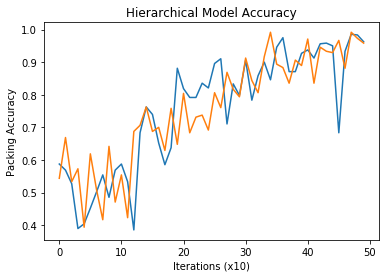

In [131]:
import matplotlib.pyplot as plt
plt.plot(accuracies2, label="trial 1")
plt.plot(accuracies3, label="trial 2")
plt.ylabel("Packing Accuracy")
plt.xlabel("Iterations (x10)")
plt.title("Hierarchical Model Accuracy")
plt.show()

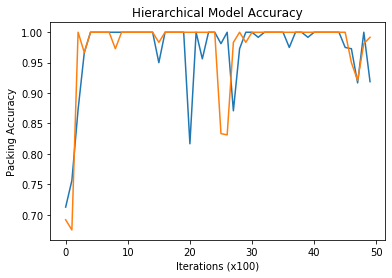

In [130]:
import matplotlib.pyplot as plt
plt.plot(accuracies, label="trial 1")
plt.plot(accuracies1, label="trial 2")
plt.ylabel("Packing Accuracy")
plt.xlabel("Iterations (x100)")
plt.title("Hierarchical Model Accuracy")
plt.show()

In [39]:
np.ones((2,2))

array([[1., 1.],
       [1., 1.]])

10
0.2
7
0.20833333333333334
8
0.3375
6
0.4166666666666667
3
0.378125
0
0.703125
2
hi
1
10
It's over
1


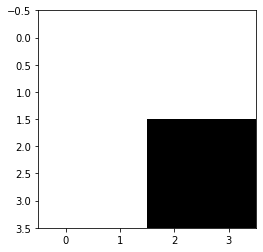

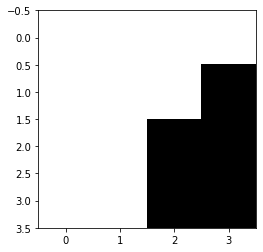

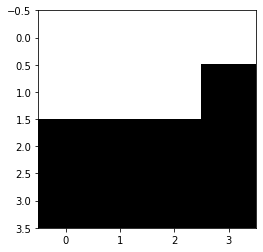

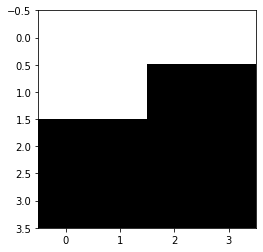

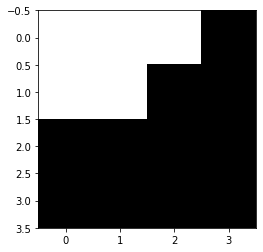

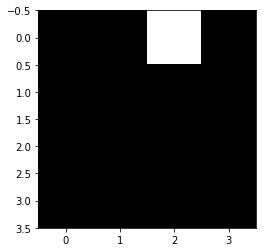

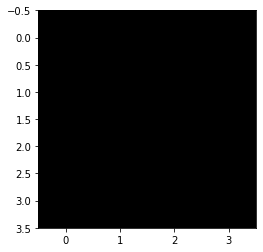

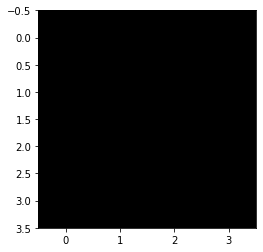

In [132]:
new_state = x.reset()
for i in range(8):
    action = y.trained_act(new_state)
    print(action)
    new_state, reward, done, _ = x.step(action)
    print(reward)
    x.render()

In [57]:
x = <__main__.PackEnv2 at 0x1379da210>

SyntaxError: invalid syntax (<ipython-input-57-66edbb7f4113>, line 1)